# Лабораторная работа 3

# 8 вариант

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.utils import plot_model
from keras.preprocessing.sequence import TimeseriesGenerator
import os
import numpy.random as rand
import random
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

AttributeError: module 'keras.backend.tensorflow_backend' has no attribute '_is_tf_1'

Загрузите из mat-файла Fort.mat ряд, содержащий отсчеты некоторого
реального ВР, всего 174 отсчета в вектор-строке, и отмасштабируйте
его в диапазон от 0 до 1, так как функция активации слоя LSTM
корректно обрабатывает значения только в данном диапазоне:

In [ ]:
file = h5py.File('Fort.mat', 'r')
data = file.get('Fort')
Fort = np.array(data)
F = Fort
scaler = MinMaxScaler(feature_range=(0, 1))
F = scaler.fit_transform(F)
F_tr = F[:150]
F_test = F[144:]
plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(np.r_[:150],F_tr, 'b')
plt.plot(np.r_[144:174],F_test, 'r')
plt.show()


Важно произвести предобработку исходных данных в формат,
понимаемый слоем LSTM-сети, в виде «порций» (batches) для
обучения/валидации. Ниже приведен пример для модели сети 6
порядка авторегрессии на (150-6) = 144 смежных точках ряда.

In [3]:
data_gen = TimeseriesGenerator(F_tr, F_tr,
 length=6, sampling_rate=1,
 batch_size=150)
batch_0 = data_gen[0]
x, y = batch_0 # вход и обучающий выход для сети
print(x.shape) # 144 точки обучения, прогноз 1 точки по 6 прошлым
xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy=y
print(xx.shape) # меняем местами размерности
print(yy.shape) #

(144, 6, 1)
(144, 1, 6)
(144, 1)


Затем составляется сама модель прогнозной сети. В простейшем
случае нам понадобится только 1 внутренний LSTM-слой и 1
выходной слой. Тогда модель строится как:

Instructions for updating:
Colocations handled automatically by placer.


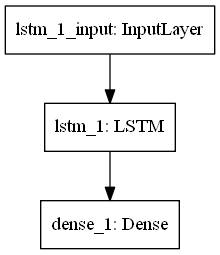

In [4]:
model = Sequential() # слои соединены последовательно
model.add(LSTM(units=20, input_shape=(1, 6))) # 20 нейронов
model.add(Dense(units = 1)) # выход одномерный
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
plot_model(model, to_file='model.png') # рисунок полученной сети

Но слои LSTM замечательны тем, что могут иметь связи между собой
кроме стандартных входов-выходов для реализации «долгой памяти».
В этом случае в коде модели необходимо это указывать. Также в такие
модели зачастую добавляют слои “Dropout”, которые со случайной
заданной вероятностью обнуляют входы следующего слоя при
обучении, тем самым позволяя избежать переобучения всей
нейронной сети в целом. Например, модель из 3 слоев LSTM может
быть построена примерно следующим образом:

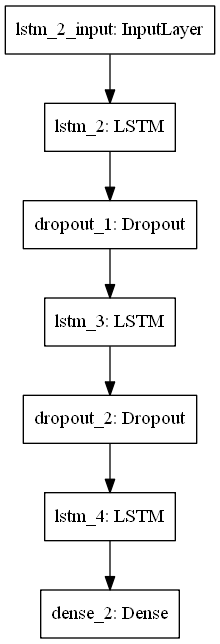

In [5]:
model = Sequential()
model.add(LSTM(units=20, return_sequences=True, input_shape=(1, 6)))
model.add(Dropout(0.2))
model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=20))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
plot_model(model, to_file='model.png')

В качестве функции оптимизации здесь задан алгоритм Adam. Adam
— adaptive moment estimation, оптимизационный алгоритм, который
сочетает в себе и идею накопления движения и идею более слабого
обновления весов для типичных признаков. Отличительная
особенность в том, что функция использует сглаженные версии
среднего и среднеквадратичного градиента. Алгоритм используется
для градиентной оптимизации стохастических целевых функций
первого порядка, основанный на адаптивных оценках моментов более
низкого порядка. Данный способ хорошо подходит для
нестационарных целей и задач с очень шумными и / или разреженными
градиентами. Во время процедуры обучения мы минимизируем
ошибку между прогнозом и фактическими наблюдениями в терминах
корня среднеквадратичной ошибки 'mean_squared_error'.

Наконец, производим обучение нашей модели.

In [6]:
model.fit(xx, yy, epochs = 100) # 100 эпох по 144 точки

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
144/144 [==============================] - 4s 28ms/step - loss: 0.2270
Epoch 2/100
144/144 [==============================] - 0s 235us/step - loss: 0.2125
Epoch 3/100
144/144 [==============================] - 0s 284us/step - loss: 0.1977
Epoch 4/100
144/144 [==============================] - 0s 255us/step - loss: 0.1821
Epoch 5/100
144/144 [==============================] - 0s 283us/step - loss: 0.1654
Epoch 6/100
144/144 [==============================] - 0s 261us/step - loss: 0.1475
Epoch 7/100
144/144 [==============================] - 0s 277us/step - loss: 0.1286
Epoch 8/100
144/144 [==============================] - 0s 213us/step - loss: 0.1079
Epoch 9/100
144/144 [==============================] - 0s 216us/step - loss: 0.0857
Epoch 10/100
144/144 [==============================] - 0s 229us/step - loss: 0.0676
Epoch 11/100
144/144 [==============================] - 0s 214us/step - loss: 0.0483
Epoch 12/100
144/144 [=====

Чтобы посмотреть, что же у нас получилось обучить, построим
ретроспективный прогноз, с переходом обратно к исходному
масштабу данных:


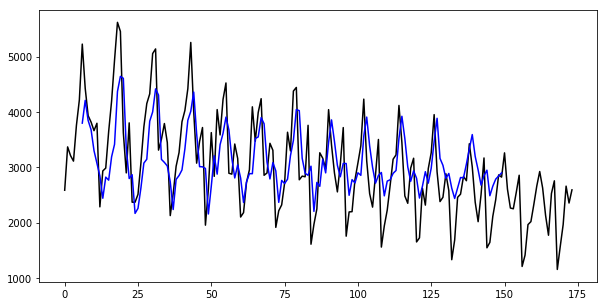

In [7]:
trainPredict = model.predict(xx)
trainPredict = scaler.inverse_transform(trainPredict)
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[6:150],trainPredict, 'b')
plt.show()


А для тестовой проверки прогноза придется исходные точки вновь
переработать в формат, понятный для модели LSTM-сети

In [8]:
data_gen = TimeseriesGenerator(F_test, F_test,
 length=6, sampling_rate=1,
 batch_size=150)
batch_0 = data_gen[0]
x, y = batch_0
xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy = y
print(xx.shape) # прогноз на 24 точки по 6 наблюдениям
print(yy.shape) #

(24, 1, 6)
(24, 1)


Строим получившийся тестовый прогноз в нужном масштабе:

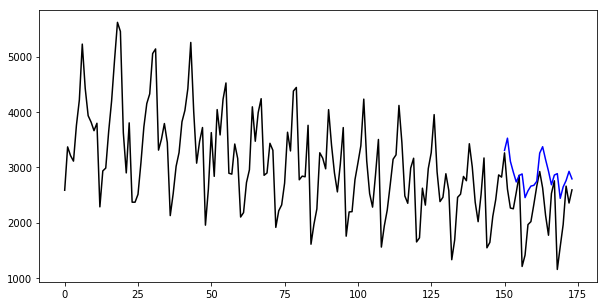

In [9]:
testPredict = model.predict(xx)
testPredict = scaler.inverse_transform(testPredict)
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[150:174],testPredict, 'b')
plt.show()

Теперь самостоятельно попробуйте подобрать такую модель и ее
параметры (число нейронов в слоях, общая структура, коэффициенты
Dropout, число предыдущих точек для прогноза, число наблюдений
для оубчения и т.д.), чтобы получить наиболее удачный результат с
Вашей точки зрения. Длина прогноза студентами выбирается
самостоятельно, она должна быть не меньше 24 отсчетов. Графики
исходного ряда Fort и прогноза строятся вместе, так как они имеют
малую длину и вполне могут поместиться рядом с достаточной
точностью.

Epoch 1/600
144/144 [==============================] - 4s 28ms/step - loss: 0.2193
Epoch 2/600
144/144 [==============================] - 0s 525us/step - loss: 0.1750
Epoch 3/600
144/144 [==============================] - 0s 608us/step - loss: 0.1053
Epoch 4/600
144/144 [==============================] - 0s 606us/step - loss: 0.0467
Epoch 5/600
144/144 [==============================] - 0s 662us/step - loss: 0.0520
Epoch 6/600
144/144 [==============================] - 0s 676us/step - loss: 0.0378
Epoch 7/600
144/144 [==============================] - 0s 653us/step - loss: 0.0372
Epoch 8/600
144/144 [==============================] - 0s 718us/step - loss: 0.0385
Epoch 9/600
144/144 [==============================] - 0s 552us/step - loss: 0.0352
Epoch 10/600
144/144 [==============================] - 0s 547us/step - loss: 0.0352
Epoch 11/600
144/144 [==============================] - 0s 504us/step - loss: 0.0343
Epoch 12/600
144/144 [==============================] - 0s 520us/step - los

144/144 [==============================] - 0s 578us/step - loss: 0.0206
Epoch 193/600
144/144 [==============================] - 0s 630us/step - loss: 0.0230
Epoch 194/600
144/144 [==============================] - 0s 546us/step - loss: 0.0219
Epoch 195/600
144/144 [==============================] - 0s 549us/step - loss: 0.0206
Epoch 196/600
144/144 [==============================] - 0s 575us/step - loss: 0.0209
Epoch 197/600
144/144 [==============================] - 0s 538us/step - loss: 0.0205
Epoch 198/600
144/144 [==============================] - 0s 518us/step - loss: 0.0221
Epoch 199/600
144/144 [==============================] - 0s 572us/step - loss: 0.0216
Epoch 200/600
144/144 [==============================] - 0s 601us/step - loss: 0.0218
Epoch 201/600
144/144 [==============================] - 0s 668us/step - loss: 0.0213
Epoch 202/600
144/144 [==============================] - 0s 655us/step - loss: 0.0212
Epoch 203/600
144/144 [==============================] - 0s 567us/st

144/144 [==============================] - 0s 670us/step - loss: 0.0202
Epoch 382/600
144/144 [==============================] - 0s 721us/step - loss: 0.0200 0s - loss: 0.019
Epoch 383/600
144/144 [==============================] - 0s 623us/step - loss: 0.0206
Epoch 384/600
144/144 [==============================] - 0s 746us/step - loss: 0.0212
Epoch 385/600
144/144 [==============================] - 0s 629us/step - loss: 0.0210
Epoch 386/600
144/144 [==============================] - 0s 535us/step - loss: 0.0198
Epoch 387/600
144/144 [==============================] - 0s 506us/step - loss: 0.0193
Epoch 388/600
144/144 [==============================] - 0s 546us/step - loss: 0.0214
Epoch 389/600
144/144 [==============================] - 0s 553us/step - loss: 0.0208
Epoch 390/600
144/144 [==============================] - 0s 578us/step - loss: 0.0221
Epoch 391/600
144/144 [==============================] - 0s 603us/step - loss: 0.0205
Epoch 392/600
144/144 [============================

144/144 [==============================] - 0s 649us/step - loss: 0.0199
Epoch 477/600
144/144 [==============================] - 0s 639us/step - loss: 0.0190
Epoch 478/600
144/144 [==============================] - 0s 653us/step - loss: 0.0186
Epoch 479/600
144/144 [==============================] - 0s 663us/step - loss: 0.0185
Epoch 480/600
144/144 [==============================] - 0s 790us/step - loss: 0.0189
Epoch 481/600
144/144 [==============================] - 0s 688us/step - loss: 0.0189
Epoch 482/600
144/144 [==============================] - 0s 682us/step - loss: 0.0190
Epoch 483/600
144/144 [==============================] - 0s 738us/step - loss: 0.0193
Epoch 484/600
144/144 [==============================] - 0s 606us/step - loss: 0.0194
Epoch 485/600
144/144 [==============================] - 0s 666us/step - loss: 0.0198
Epoch 486/600
144/144 [==============================] - 0s 617us/step - loss: 0.0175
Epoch 487/600
144/144 [==============================] - 0s 633us/st

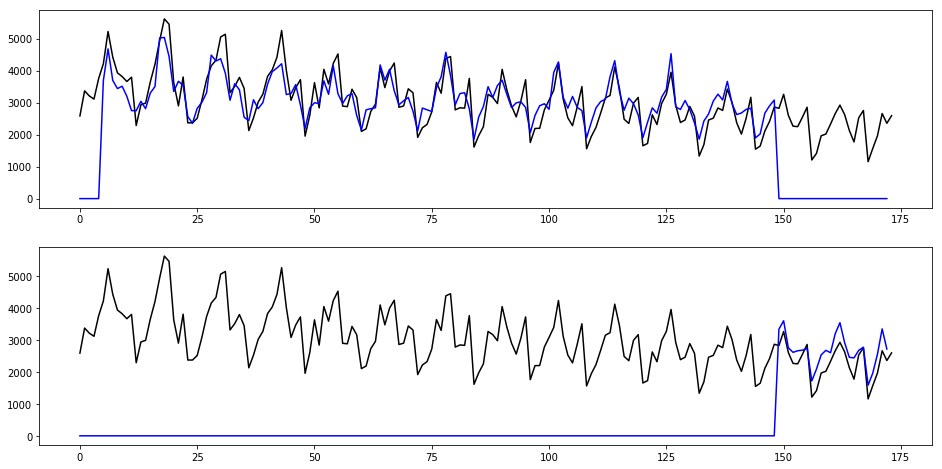

In [10]:
data_gen = TimeseriesGenerator(F_tr, F_tr,length=6, sampling_rate=1,batch_size=150)
batch_0 = data_gen[0]
x, y = batch_0 # вход и обучающий выход для сети
xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy=y

model = Sequential()
model.add(LSTM(units=120, return_sequences=True, input_shape=(1, 6)))
model.add(Dropout(0.3))
model.add(LSTM(units=240, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=120))
model.add(Dropout(0.3))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
plot_model(model, to_file='model.png')

model.fit(xx, yy, epochs = 600) # 100 эпох по 144 точки

trainPredict = model.predict(xx)
trainPredict = scaler.inverse_transform(trainPredict)

data_gen = TimeseriesGenerator(F_test, F_test,length=6, sampling_rate=1,batch_size=150)
batch_0 = data_gen[0]
x, y = batch_0
xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy = y

testPredict = model.predict(xx)
testPredict = scaler.inverse_transform(testPredict)

fig, ax = plt.subplots(2, 1, figsize=(16, 8))

ax[0].plot(Fort, 'k', label='original')
ax[0].plot(np.concatenate((np.zeros((5, 1)),trainPredict,np.zeros((24, 1))),axis=0), 'b', label='predict')

ax[1].plot(Fort, 'k', label='original')
ax[1].plot(np.concatenate((np.zeros((149, 1)),testPredict),axis=0), 'b', label='predict')

plt.show()

Постройте также прогноз данным методом для своего модельного
ВР (по вариантам) и самостоятельно выберите для него параметры.

Декомпозиция ВР вида экспонента + степ. ряд высокой степени + шум

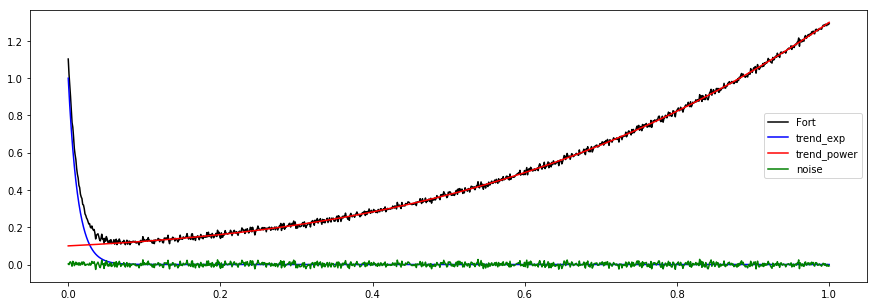

In [44]:
t = np.linspace(0, 1, 1000)

a = 80
trend_exp = np.exp(-a*t)

b0 = 0.1
b1 = 0.2
b2 = 0.4
b3 = 0.6
trend_power = b0+b1*t+b2*t**2+b3*t**3

noise = 0.01*rand.randn(len(t))
N=len(t)

Fort = trend_exp+trend_power+noise
Fort = np.array(Fort)

plt.figure(figsize = (15, 5))
plt.plot(t, Fort, 'k', label = 'Fort')
plt.plot(t, trend_exp, 'b', label = 'trend_exp')
plt.plot(t, trend_power, 'r', label = 'trend_power')
plt.plot(t, noise, 'g', label = 'noise')
plt.legend()
plt.show()

In [68]:
l = 200
batch_size_p = 800

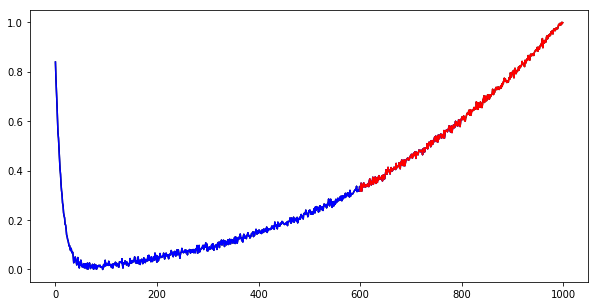

In [69]:
Fort = Fort.reshape(-1, 1)
F = Fort
scaler = MinMaxScaler(feature_range=(0, 1))
F = scaler.fit_transform(F)
F_tr = F[:batch_size_p]
F_test = F[batch_size_p-l:]
plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(np.r_[:batch_size_p],F_tr, 'b')
plt.plot(np.r_[batch_size_p-l:1000],F_test, 'r')
plt.show()

Epoch 1/100
600/600 [==============================] - 6s 10ms/step - loss: 0.0683 - accuracy: 0.0000e+00
Epoch 2/100
600/600 [==============================] - 0s 375us/step - loss: 0.0147 - accuracy: 0.0000e+00
Epoch 3/100
600/600 [==============================] - 0s 364us/step - loss: 0.0045 - accuracy: 0.0000e+00
Epoch 4/100
600/600 [==============================] - 0s 369us/step - loss: 0.0022 - accuracy: 0.0000e+00
Epoch 5/100
600/600 [==============================] - 0s 422us/step - loss: 0.0014 - accuracy: 0.0000e+00
Epoch 6/100
600/600 [==============================] - 0s 429us/step - loss: 0.0013 - accuracy: 0.0000e+00
Epoch 7/100
600/600 [==============================] - 0s 438us/step - loss: 0.0013 - accuracy: 0.0000e+00
Epoch 8/100
600/600 [==============================] - 0s 443us/step - loss: 0.0012 - accuracy: 0.0000e+00
Epoch 9/100
600/600 [==============================] - 0s 436us/step - loss: 0.0010 - accuracy: 0.0000e+00
Epoch 10/100
600/600 [================

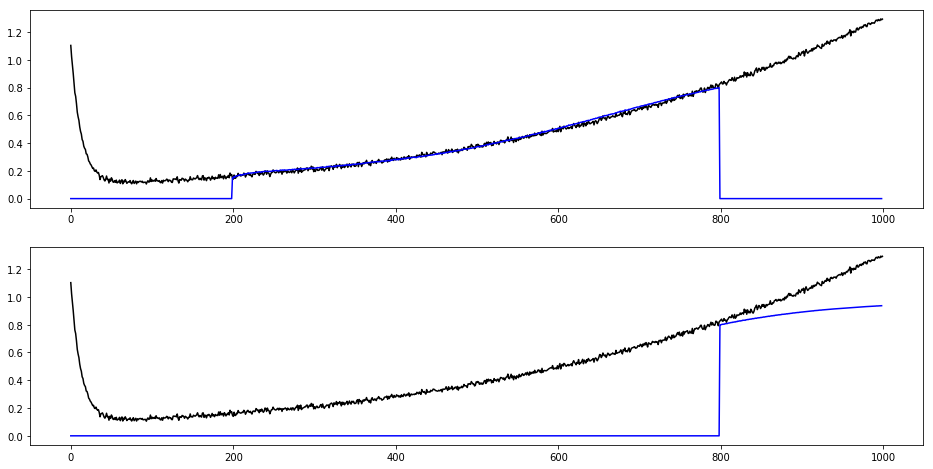

In [107]:
data_gen = TimeseriesGenerator(F_tr, F_tr,length=l, sampling_rate=2,batch_size=batch_size_p)
batch_0 = data_gen[0]
x, y = batch_0 # вход и обучающий выход для сети
xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy=y

model = Sequential()
model.add(LSTM(units=20, return_sequences=True, input_shape=(1, 100)))
model.add(Dropout(0.1))
model.add(LSTM(units=40, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=20))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['accuracy'])
plot_model(model, to_file='model.png')

model.fit(xx, yy, epochs = 100) # 100 эпох по 144 точки

trainPredict = model.predict(xx)
trainPredict = scaler.inverse_transform(trainPredict)

data_gen = TimeseriesGenerator(F_test, F_test,length=l, sampling_rate=2,batch_size=batch_size_p)
batch_0 = data_gen[0]
x, y = batch_0
xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy = y

testPredict = model.predict(xx)
testPredict = scaler.inverse_transform(testPredict)

fig, ax = plt.subplots(2, 1, figsize=(16, 8))

ax[0].plot(Fort, 'k', label='original')
ax[0].plot(np.concatenate((np.zeros((l-1, 1)),trainPredict,np.zeros((len(Fort)-batch_size_p, 1))),axis=0), 'b', label='predict')

ax[1].plot(Fort, 'k', label='original')
ax[1].plot(np.concatenate((np.zeros((batch_size_p-1, 1)),testPredict),axis=0), 'b', label='predict')

plt.show()